Variables Terminology
1) original_dataset = containing the actual data
2) modified_dataset = containing the outlier free data

3) features1 & target1 = features and target extracted from original data
4) features2 & target2 = features and target extracted from outlier free data

5) X_train, X_test, y_train, y_test = train test split of original data
6) modified_X_train, modified_X_test, modified_y_train, modified_y_test = train test split of modified data

7) scaled_X_train1, scaled_X_test1 = scaled version of original data's split
8) scaled_X_train2, scaled_X_test2 = scaled version of modified data's split

Getting all the dependencies.

In [5]:
# basic imports
import pandas as pd

# dataset preprocessing dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# models dependencies
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# scoring metrics dependencies
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# feature selection dependencies
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# visualisation dependencies
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

A) Getting the dataset and preparing it.

In [6]:
original_dataset = pd.read_csv('updated_pollution_dataset_2.csv')
original_dataset.head()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,Air Quality
0,27.1,39.1,6.1,6.3,13.5,5.3,1.15,11.1,551,Good
1,26.5,70.7,6.9,16.0,21.9,5.6,1.01,12.7,303,Good
2,39.4,96.6,14.6,35.5,42.9,17.9,1.82,3.1,674,Poor
3,41.7,82.5,1.7,15.8,31.1,12.7,1.80,4.6,735,Poor
4,29.4,93.8,10.3,22.7,45.1,11.8,2.03,5.4,486,Poor


In [7]:
original_dataset.describe()

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density
count,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000,4250.000000
mean,30.021671,69.935576,20.057929,30.151482,26.399671,10.004471,1.500428,8.684212,497.283059
std,7.079486,16.402863,25.140063,28.294709,9.415399,7.111211,0.586232,3.778317,158.671435
min,13.400000,36.000000,0.000000,-0.200000,7.400000,-6.200000,0.650000,2.500000,188.000000
25%,24.700000,57.800000,4.500000,11.700000,19.500000,4.900000,1.010000,5.225000,376.000000
50%,28.700000,69.600000,11.600000,21.200000,25.000000,7.500000,1.310000,9.700000,494.000000
75%,34.500000,80.200000,25.600000,37.800000,32.500000,14.175000,1.930000,11.300000,601.000000
max,58.600000,128.100000,295.000000,315.800000,64.900000,44.900000,3.720000,25.800000,957.000000


My Observations from the above data

    1) Few outliers in PM2.5, PM10 and SO2 column - having negative and zero values (min values in decribe method gauged this)
    2) As measuring unit of pollutants is not specified, I will take the values as is, can't decide whether the range is correct or not. For example temperature would range differently in celcius and farenheit.
    3) There are no missing values in the dataset as count matches the total rows for all numeric columns.
    4) But this describe misses out on the text column i.e Air Quality, so we will run the null check.

In [8]:
#let's do the missing value analysis as we have one non-numeric column
original_dataset.isnull().sum()

Temperature                      0
Humidity                         0
PM2.5                            0
PM10                             0
NO2                              0
SO2                              0
CO                               0
Proximity_to_Industrial_Areas    0
Population_Density               0
Air Quality                      0
dtype: int64

Extracting the input features and the target variable and also converting the labels to 0 or 1 for calculational efficiency.

In [9]:
# Getting the features and target variables from the original data

features1 = original_dataset.drop('Air Quality', axis =1)

target1 = original_dataset["Air Quality"].map(lambda val: 1 if val == "Good" else 0)

#some sanity checks
target1.head()
target1.shape


# Getting the train and test splits for the original data

X_train, X_test, y_train, y_test = train_test_split(features1, target1, test_size=0.2, random_state=42)

# sanity checks
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3400, 9) (850, 9) (3400,) (850,)


In [10]:
#how many negative or zero values do we have? - considering these as outliers because concentration can't be negative or 0.
zero_counts = (features1 <= 0).sum()
zero_counts

Temperature                       0
Humidity                          0
PM2.5                            18
PM10                              2
NO2                               0
SO2                              28
CO                                0
Proximity_to_Industrial_Areas     0
Population_Density                0
dtype: int64

Inferences
1) Negative values seem to be really less, i.e 48 in total, roughly 1% of the entire dataset. From here we will test our models parallely on two datasets, one is the original i.e 4250 in number and another one with certain outliers removed i.e 4202 in number.

2) Algorithms being tested are 
    a) Logistic Regression
    b) Support Vector Machines
    c) Decision Tree
    d) Random Forest

3) As the dataset is fairly small and clean, we will decide next steps only after looking at different metrics derived from above testing.

In [11]:
# In this dataset I have dropped the negative and zero values
modified_dataset = original_dataset[original_dataset["SO2"] > 0]
modified_dataset = modified_dataset[modified_dataset["PM10"] > 0]
modified_dataset = modified_dataset[modified_dataset["PM2.5"] > 0]

#sanity check
modified_dataset.shape

(4202, 10)

In [12]:
# Getting the features and target variables from the modified data

features2 = modified_dataset.drop('Air Quality', axis = 1)

target2 = modified_dataset["Air Quality"].map(lambda val: 1 if val == "Good" else 0)

#some sanity checks
target2.head()
target2.shape

#train and test splits for modified data
modified_X_train, modified_X_test, modified_y_train, modified_y_test = train_test_split(features2, target2, test_size=0.2, random_state=42)

#sanity check
print(modified_X_train.shape, modified_X_test.shape, modified_y_train.shape, modified_y_test.shape)

(3361, 9) (841, 9) (3361,) (841,)


A2) Checking the range of entire dataset

<Axes: >

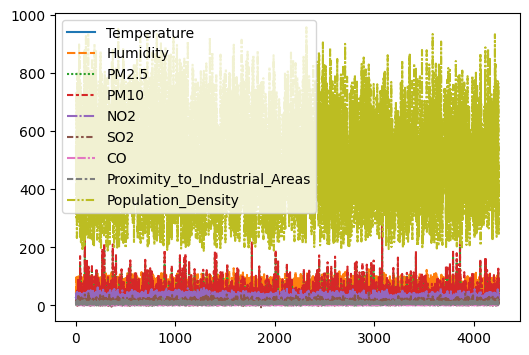

In [13]:
plt.figure(figsize=(6,4))

sns.lineplot(data=original_dataset)

As we can see from above plot there is a huge variation in the range of data features, they range from 0.1 to 957 - so let's first standardise them.

In [14]:
# Standardising the original data

scaler1 = StandardScaler()
scaled_X_train1 = scaler1.fit_transform(X_train)
scaled_X_test1 = scaler1.transform(X_test)


In [15]:
#Standardising the modified data

scaler2 = StandardScaler()
scaled_X_train2 = scaler2.fit_transform(modified_X_train)
scaled_X_test2 = scaler2.transform(modified_X_test)

B) Model Selection

    1) Logistic Regression
    2) Support Vector Machine
    3) Decision Tree
    4) Random Forest

# Running all the models for original dataset first

In [16]:
# 1) Logistic Regression Model

original_LR_model = LogisticRegression()
original_LR_model.fit(scaled_X_train1, y_train)

LR_y_pred1 = original_LR_model.predict(scaled_X_test1)

LR_accuracy1 = accuracy_score(y_test, LR_y_pred1)

print("Accuracy: {:.2f}%".format(LR_accuracy1 * 100))
print(confusion_matrix(y_test, LR_y_pred1))
print(classification_report(y_test, LR_y_pred1))

Accuracy: 97.29%
[[280  16]
 [  7 547]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96       296
           1       0.97      0.99      0.98       554

    accuracy                           0.97       850
   macro avg       0.97      0.97      0.97       850
weighted avg       0.97      0.97      0.97       850



In [17]:
# 2) Support Vector machine

original_svm_model = SVC()
original_svm_model.fit(scaled_X_train1, y_train)

SVM_y_pred1 = original_svm_model.predict(scaled_X_test1)

SVM_accuracy1 = accuracy_score(y_test, SVM_y_pred1)

print("Accuracy: {:.2f}%".format(SVM_accuracy1 * 100))
print(confusion_matrix(y_test, SVM_y_pred1))
print(classification_report(y_test, SVM_y_pred1))

Accuracy: 97.29%
[[282  14]
 [  9 545]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       296
           1       0.97      0.98      0.98       554

    accuracy                           0.97       850
   macro avg       0.97      0.97      0.97       850
weighted avg       0.97      0.97      0.97       850



In [18]:
# 3) Decision Tree Classifier

original_dtc_model = DecisionTreeClassifier()
original_dtc_model.fit(scaled_X_train1, y_train)

DTC_y_pred1 = original_dtc_model.predict(scaled_X_test1)

DTC_accuracy1 = accuracy_score(y_test, DTC_y_pred1)

print("Accuracy: {:.2f}%".format(DTC_accuracy1 * 100))
print(confusion_matrix(y_test, DTC_y_pred1))
print(classification_report(y_test, DTC_y_pred1))


Accuracy: 97.29%
[[285  11]
 [ 12 542]]
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       296
           1       0.98      0.98      0.98       554

    accuracy                           0.97       850
   macro avg       0.97      0.97      0.97       850
weighted avg       0.97      0.97      0.97       850



In [19]:
original_dtc_model.feature_importances_

array([0.01808169, 0.0276628 , 0.00677245, 0.0051159 , 0.04116349,
       0.02743233, 0.77573596, 0.08783525, 0.01020013])

In [20]:
# 4) Random Forest Classifier - ensemble of decision trees
original_rfc_model = RandomForestClassifier(n_estimators=50)
original_rfc_model.fit(scaled_X_train1, y_train)

RFC_y_pred1 = original_rfc_model.predict(scaled_X_test1)

RFC_accuracy1 = accuracy_score(y_test, RFC_y_pred1)

print("Accuracy: {:.2f}%".format(RFC_accuracy1 * 100))
print(confusion_matrix(y_test, RFC_y_pred1))
print(classification_report(y_test, RFC_y_pred1))

Accuracy: 97.41%
[[282  14]
 [  8 546]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       296
           1       0.97      0.99      0.98       554

    accuracy                           0.97       850
   macro avg       0.97      0.97      0.97       850
weighted avg       0.97      0.97      0.97       850



# Running all the models for modified dataset

In [21]:
# 1) Logistic Regression Model

modified_LR_model = LogisticRegression()
modified_LR_model.fit(scaled_X_train2, modified_y_train)

LR_y_pred2 = modified_LR_model.predict(scaled_X_test2)

LR_accuracy2 = accuracy_score(modified_y_test, LR_y_pred2)

print("Accuracy: {:.2f}%".format(LR_accuracy2 * 100))
print(confusion_matrix(modified_y_test, LR_y_pred2))
print(classification_report(modified_y_test, LR_y_pred2))

Accuracy: 97.98%
[[309   8]
 [  9 515]]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       317
           1       0.98      0.98      0.98       524

    accuracy                           0.98       841
   macro avg       0.98      0.98      0.98       841
weighted avg       0.98      0.98      0.98       841



In [22]:
# 2) Support Vector machine

modified_svm_model = SVC()
modified_svm_model.fit(scaled_X_train2, modified_y_train)

SVM_y_pred2 = modified_svm_model.predict(scaled_X_test2)

SVM_accuracy2 = accuracy_score(modified_y_test, SVM_y_pred2)

print("Accuracy: {:.2f}%".format(SVM_accuracy2 * 100))
print(confusion_matrix(modified_y_test, SVM_y_pred2))
print(classification_report(modified_y_test, SVM_y_pred2))

Accuracy: 98.45%
[[310   7]
 [  6 518]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       317
           1       0.99      0.99      0.99       524

    accuracy                           0.98       841
   macro avg       0.98      0.98      0.98       841
weighted avg       0.98      0.98      0.98       841



In [23]:
# 3) Decision Tree Classifier

modified_dtc_model = DecisionTreeClassifier()
modified_dtc_model.fit(scaled_X_train2, modified_y_train)

DTC_y_pred2 = modified_dtc_model.predict(scaled_X_test2)

DTC_accuracy2 = accuracy_score(modified_y_test, DTC_y_pred2)

print("Accuracy: {:.2f}%".format(DTC_accuracy2 * 100))
print(confusion_matrix(modified_y_test, DTC_y_pred2))
print(classification_report(modified_y_test, DTC_y_pred2))


Accuracy: 97.27%
[[302  15]
 [  8 516]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       317
           1       0.97      0.98      0.98       524

    accuracy                           0.97       841
   macro avg       0.97      0.97      0.97       841
weighted avg       0.97      0.97      0.97       841



In [24]:
modified_dtc_model.feature_importances_

array([0.02102914, 0.02900236, 0.00299124, 0.01654311, 0.02863108,
       0.02234752, 0.76819281, 0.10397408, 0.00728867])

In [25]:
# 4) Random Forest Classifier - ensemble of decision trees
modified_rfc_model = RandomForestClassifier(n_estimators=50)
modified_rfc_model.fit(scaled_X_train2, modified_y_train)

RFC_y_pred2 = modified_rfc_model.predict(scaled_X_test2)

RFC_accuracy2 = accuracy_score(modified_y_test, RFC_y_pred2)

print("Accuracy: {:.2f}%".format(RFC_accuracy2 * 100))
print(confusion_matrix(modified_y_test, RFC_y_pred2))
print(classification_report(modified_y_test, RFC_y_pred2))

Accuracy: 98.57%
[[313   4]
 [  8 516]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       317
           1       0.99      0.98      0.99       524

    accuracy                           0.99       841
   macro avg       0.98      0.99      0.98       841
weighted avg       0.99      0.99      0.99       841



In [26]:
# Training Set accuracies for all the 4 algorithms

LR_y_pred_train1 = original_LR_model.predict(scaled_X_train1)

LR_accuracy_train1 = accuracy_score(y_train, LR_y_pred_train1)

SVM_y_pred_train1 = original_svm_model.predict(scaled_X_train1)

SVM_accuracy_train1 = accuracy_score(y_train, SVM_y_pred_train1)

DTC_y_pred_train1 = original_dtc_model.predict(scaled_X_train1)

DTC_accuracy_train1 = accuracy_score(y_train, DTC_y_pred_train1)


RFC_y_pred_train1 = original_rfc_model.predict(scaled_X_train1)

RFC_accuracy_train1 = accuracy_score(y_train, RFC_y_pred_train1)

In [27]:
# Training Set accuracies for all the 4 algorithms

LR_y_pred_train2 = modified_LR_model.predict(scaled_X_train2)

LR_accuracy_train2 = accuracy_score(modified_y_train, LR_y_pred_train2)

SVM_y_pred_train2 = modified_svm_model.predict(scaled_X_train2)

SVM_accuracy_train2 = accuracy_score(modified_y_train, SVM_y_pred_train2)

DTC_y_pred_train2 = modified_dtc_model.predict(scaled_X_train2)

DTC_accuracy_train2 = accuracy_score(modified_y_train, DTC_y_pred_train2)


RFC_y_pred_train2 = modified_rfc_model.predict(scaled_X_train2)

RFC_accuracy_train2 = accuracy_score(modified_y_train, RFC_y_pred_train2)

C) Metrics for all the above 4 models for both the dataset

    1) Using 80:20 split
    2) Using two kinds of datasets - original & modified(i.e. outlier free)

In [28]:

orig_data = {
    'Model': ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest Classifier'],
    'Taining Set Accuracy': [LR_accuracy_train1, SVM_accuracy_train1, DTC_accuracy_train1, RFC_accuracy_train1],
    'Test Set Accuracy':[LR_accuracy1, SVM_accuracy1, DTC_accuracy1, RFC_accuracy1]
}


orig_df = pd.DataFrame(orig_data)


modified_data ={
    'Model': ['Logistic Regression', 'Support Vector Machine', 'Decision Tree', 'Random Forest Classifier'],
    'Taining Set Accuracy': [LR_accuracy_train2, SVM_accuracy_train2, DTC_accuracy_train2, RFC_accuracy_train2],
    'Test Set Accuracy':[LR_accuracy2, SVM_accuracy2, DTC_accuracy2, RFC_accuracy2]
}

modified_df = pd.DataFrame(modified_data)


print("Metrics for original data")
print(orig_df)
print("--------------------------------")
print("Metrics for engineered data")
print(modified_df)

Metrics for original data
                      Model  Taining Set Accuracy  Test Set Accuracy
0       Logistic Regression              0.977059           0.972941
1    Support Vector Machine              0.984706           0.972941
2             Decision Tree              1.000000           0.972941
3  Random Forest Classifier              1.000000           0.974118
--------------------------------
Metrics for engineered data
                      Model  Taining Set Accuracy  Test Set Accuracy
0       Logistic Regression              0.976198           0.979786
1    Support Vector Machine              0.980958           0.984542
2             Decision Tree              1.000000           0.972652
3  Random Forest Classifier              1.000000           0.985731


In [29]:
# Let's derive the correlation matrix first

#okay so we need all numerical entries to get the correlation matrix

#let's create an entire new data frame and not touch the above setup

new_df = pd.read_csv('updated_pollution_dataset_2.csv')

quality = original_dataset['Air Quality'].map(lambda val: 1 if val == "Good" else 0)

new_df['quality'] = quality

new_df = new_df.drop('Air Quality', axis=1)

correlation_matrix = new_df.corr()

correlation_matrix

,Temperature,Humidity,PM2.5,PM10,NO2,SO2,CO,Proximity_to_Industrial_Areas,Population_Density,quality
Temperature,1.000000,0.505324,0.354834,0.461712,0.623888,0.600470,0.713907,-0.627069,0.517086,-0.696016
Humidity,0.505324,1.000000,0.295273,0.388177,0.527357,0.494397,0.601310,-0.516630,0.444821,-0.600894
PM2.5,0.354834,0.295273,1.000000,0.972610,0.366690,0.330682,0.425017,-0.342054,0.308384,-0.393885
PM10,0.461712,0.388177,0.972610,1.000000,0.476833,0.436771,0.551315,-0.457790,0.400210,-0.521734
NO2,0.623888,0.527357,0.366690,0.476833,1.000000,0.604779,0.735544,-0.645217,0.543809,-0.727564
SO2,0.600470,0.494397,0.330682,0.436771,0.604779,1.000000,0.706209,-0.606691,0.508033,-0.694677
CO,0.713907,0.601310,0.425017,0.551315,0.735544,0.706209,1.000000,-0.740639,0.625894,-0.834948
Proximity_to_Industrial_Areas,-0.627069,-0.516630,-0.342054,-0.457790,-0.645217,-0.606691,-0.740639,1.000000,-0.541601,0.692453
Population_Density,0.517086,0.444821,0.308384,0.400210,0.543809,0.508033,0.625894,-0.541601,1.000000,-0.611244
quality,-0.696016,-0.600894,-0.393885,-0.521734,-0.727564,-0.694677,-0.834948,0.692453,-0.611244,1.000000


1) CO and Proximity_to_industrial_Areas show the highest of correlations with the target variable
2) There is only one positive relationship - with proximity_to_industrial_areas

<Axes: xlabel='Proximity_to_Industrial_Areas', ylabel='CO'>

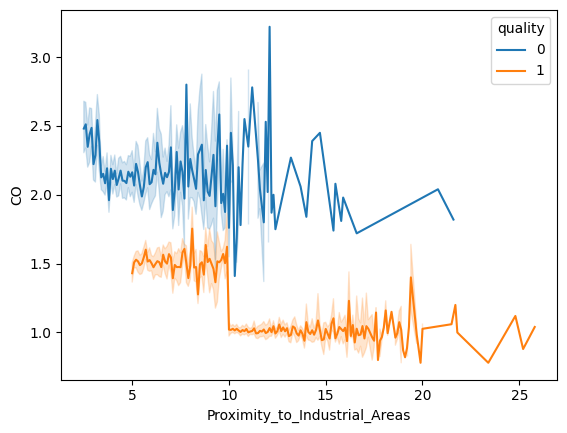

In [30]:
sns.lineplot(x='Proximity_to_Industrial_Areas', y='CO', data = new_df, hue='quality')

D) Performing Feature Selection, let's see if it increases the accuracy
    1) Using f_classif, mutual_info_classif

However the accuracy actually dropped after using feature selection, so let'snot delve deeper. I have presented one of its case.

In [31]:
selector1 = SelectKBest(f_classif, k = 3)
X_new = selector1.fit_transform(X_train, y_train)

# some sanity checks
X_new[:5]
X_new.shape
y_train.shape

(3400,)

In [32]:
X_test_new = selector1.transform(X_test)
selected_model = LogisticRegression()
selected_model.fit(X_new, y_train)

selected_pred = selected_model.predict(X_test_new)

selected_accuracy = accuracy_score(y_test, selected_pred)
selected_accuracy

0.9564705882352941

In [33]:
selector2 = SelectKBest(mutual_info_classif, k = 9)
X_new2 = selector2.fit_transform(X_train, y_train)
X_new2[:5]

array([[ 25.8 ,  54.7 ,  10.2 ,  15.8 ,  14.2 ,   5.  ,   1.03,  10.2 ,
        535.  ],
       [ 42.1 ,  87.1 , 168.6 , 188.2 ,  30.9 ,  14.8 ,   2.94,   3.2 ,
        759.  ],
       [ 46.8 , 117.3 ,  21.6 ,  29.6 ,  25.3 ,  26.7 ,   2.31,   6.4 ,
        712.  ],
       [ 46.  ,  90.9 ,  11.  ,  30.8 ,  26.2 ,  15.  ,   1.78,   5.6 ,
        736.  ],
       [ 36.1 ,  77.3 ,  40.8 ,  50.4 ,  23.1 ,  13.1 ,   2.04,   5.2 ,
        615.  ]])

In [34]:
X_test_new2 = selector2.transform(X_test)
selected_model2 = SVC()
selected_model2.fit(X_new2, y_train)

selected_pred2 = selected_model2.predict(X_test_new2)
selected_accuracy2 = accuracy_score(y_test, selected_pred)
selected_accuracy2

0.9564705882352941